In [145]:
library(tidyverse)
library(repr)
library(tidymodels)
library(RColorBrewer)
options(repr.matrix.max.rows = 30)

set.seed(8205)

 # Reading in Heart Disease Data

In [146]:

#download.file("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.switzerland.data",
            #  destfile = "./switzerland_data.data")

#read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/switzerland.data/processed.switzerland.data")

cleveland_data <- read_csv("data/processed.cleveland.data", col_names = FALSE) |>
    rename(age      = X1,      # Age in years
           sex      = X2,      # Sex (1 = male, 0 = female)
           cp       = X3,      # Chest pain type 
                               # - 1 : typical angina
                               # - 2 : atypical angina
                               # - 3 : non-anginal pain
                               # - 4 : asymptomatic
           trestbps = X4,      # Resting blood pressure (mmHg)
           chol     = X5,      # Serum cholestoral (mg/dL)
           fbs      = X6,      # Fasting blood sugar > 120 mg/dL (1 = true, 0 = false)
           restecg  = X7,      # Resting electrocardiographic results 
                               # - 0 : normal,
                               # - 1 : having ST-T wave abnormality (T wave inversions and/or ST 
                               #       elevation or depression of > 0.05 mV)
                               # - 2 : showing probable or definite left ventricular hypertrophy by Estes' criteria
           thalach  = X8,      # Maximum heart rate achieved
           exang    = X9,      # Exercise induced angina (0 = no, 1 = yes)
           oldpeak  = X10,     # ST depression induced by exercise relative to rest
           slope    = X11,     # The slope of the peak exercise ST segment
                               # - 1 : upsloping
                               # - 2 : flat
                               # - 3 : downsloping
           ca       = X12,     # Number of major vessels (0-3) colored by flourosopy
           thal     = X13,     # 3 = normal; 6 = fixed defect; 7 = reversable defect
           num      = X14)     # diagnosis of heart disease (angiographic disease status)

cleveland_data

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0
62,0,4,140,268,0,2,160,0,3.6,3,2.0,3.0,3
57,0,4,120,354,0,0,163,1,0.6,1,0.0,3.0,0
63,1,4,130,254,0,2,147,0,1.4,2,1.0,7.0,2


# Data wrangling

In [147]:
cleveland_data <- cleveland_data |>
    mutate(age      = as.integer(age),
           sex      = as.factor(sex),
           cp       = as.factor(cp),
           trestbps = as.integer(trestbps),
           chol     = as.integer(chol),
           fbs      = as.factor(fbs),
           restecg  = as.factor(restecg),
           thalach  = as.integer(thalach),
           exang    = as.factor(exang),
           oldpeak  = as.double(oldpeak),
           slope    = as.factor(slope),
           ca       = as.integer(ca),
           thal     = as.factor(thal),
           num      = as.factor(num))

cleveland_data

Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<int>,<fct>,<fct>,<int>,<int>,<fct>,<fct>,<int>,<fct>,<dbl>,<fct>,<int>,<fct>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0,3.0,0
56,1,2,120,236,0,0,178,0,0.8,1,0,3.0,0
62,0,4,140,268,0,2,160,0,3.6,3,2,3.0,3
57,0,4,120,354,0,0,163,1,0.6,1,0,3.0,0
63,1,4,130,254,0,2,147,0,1.4,2,1,7.0,2


In [148]:
# Splitting the data into training and testing sets
cleveland_split <- initial_split(cleveland_data, prop = 0.75, strata = num)
cleveland_training <- training(cleveland_split) 
cleveland_testing <- testing(cleveland_split)

# Exploratory data analysis

### Heart Disease Summary

In [149]:
target_summary <- cleveland_training |>
    group_by(num) |>
    summarize(count = n())
target_summary

num,count
<fct>,<int>
0,123
1,42
2,26
3,27
4,8


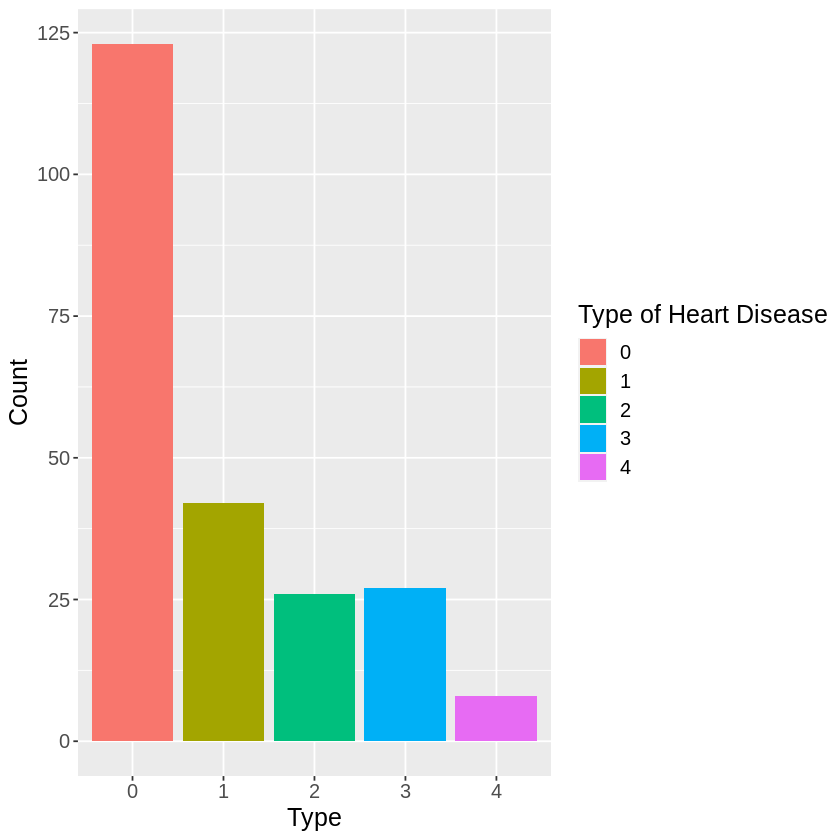

In [150]:
target_summary_plot <- target_summary |>
    ggplot(aes(x =  num, y = count, fill = num)) +
    geom_bar(stat = "identity") +
    labs(x = "Type", y = "Count", fill = "Type of Heart Disease") +
    theme(text = element_text(size = 15))

target_summary_plot

From the dataset, the majority of patients do not have any presence of heart disease. For those who have presence of a heart disease, most have **Type 1** whereas **Type 4** is the least common.

### Demographics

In [151]:
demographic_summary <- cleveland_training |>
    group_by(sex) |>
    summarize(count = n(), average_age = mean(age))
demographic_summary

sex,count,average_age
<fct>,<int>,<dbl>
0,73,56.06849
1,153,53.66667


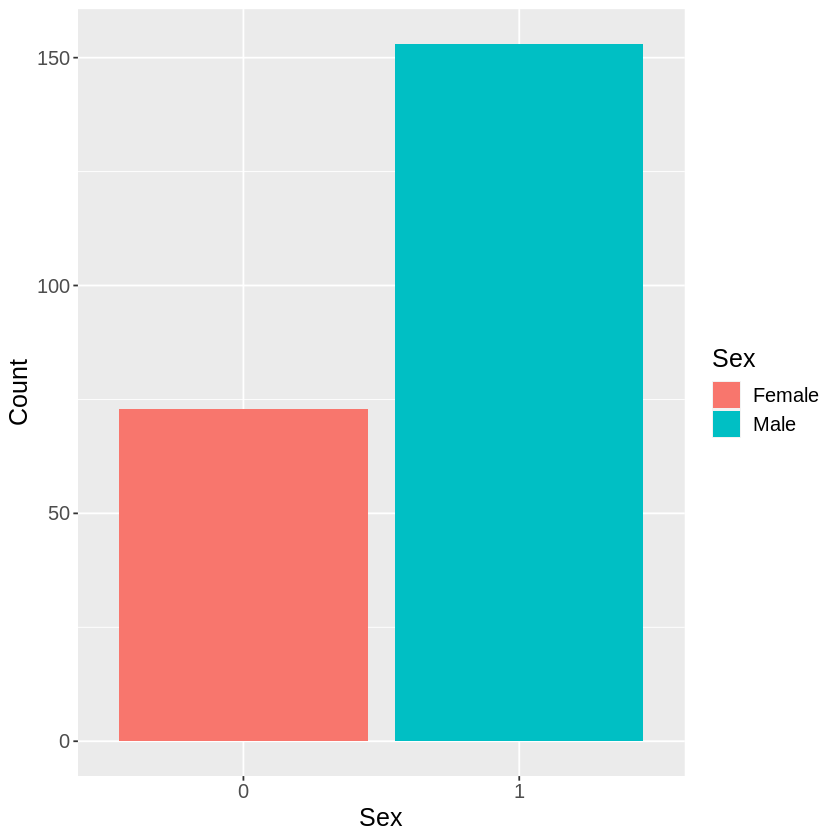

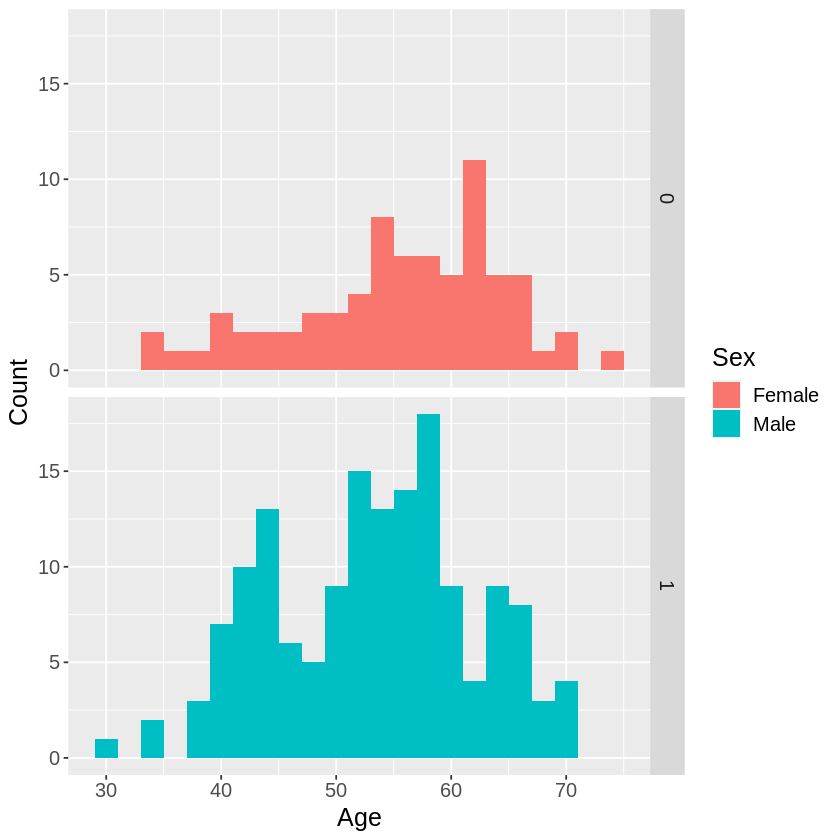

In [152]:
demographic_sex_summary_plot <- demographic_summary |>
    ggplot(aes(x =  sex, y = count, fill = sex)) +
    geom_bar(stat = "identity") +
    labs(x = "Sex", y = "Count", fill = "Sex") +
    scale_fill_discrete(labels = c("Female", "Male")) +
    theme(text = element_text(size = 15))

demographic_age_summary_plot <- cleveland_training |>
    ggplot(aes(x =  age, fill = sex)) +
    geom_histogram(binwidth = 2) +
    labs(x = "Age", y =  "Count", fill = "Sex") +
    scale_fill_discrete(labels = c("Female", "Male")) +
    facet_grid(rows = vars(sex)) +
    theme(text = element_text(size = 15))

demographic_sex_summary_plot
demographic_age_summary_plot

The number of male double that of female participants. The average age for this dataset is around 54 years old. In addition, the average age of the male is slightly younger than female participants.

### Blood Pressure

In [153]:
average_restbps <- cleveland_training |>
    summarize(average_restbps = mean(trestbps))
average_restbps

average_restbps
<dbl>
132.3319


The average resting blood pressure of all participants is 132*mmHg*. Let's see how this would affect the type of heart disease.

In [154]:
average_restbps_by_type <- cleveland_training |>
    group_by(num) |>
    summarize(average_restbps = mean(trestbps))
average_restbps_by_type

num,average_restbps
<fct>,<dbl>
0,128.8293
1,135.7143
2,136.2692
3,136.5926
4,141.2500


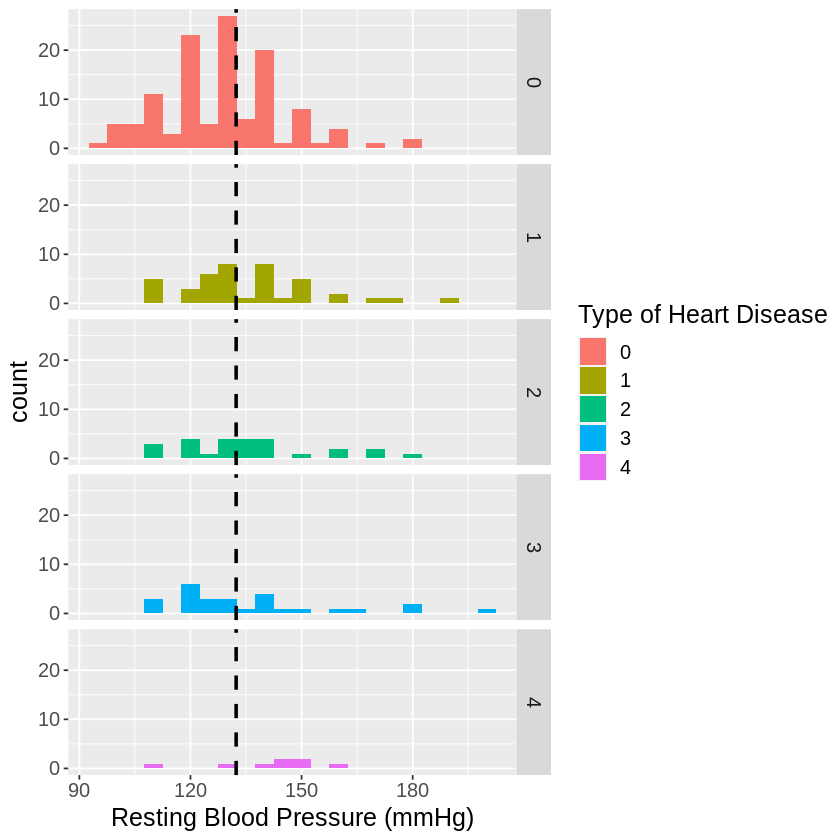

In [168]:
restbps_summary_plot <- cleveland_training |>
    ggplot(aes(x = trestbps, fill = num)) +
    geom_histogram(binwidth = 5) +
    geom_vline(xintercept = 132.33, linetype = "dashed", size = 1.0) +
    labs(x = "Resting Blood Pressure (mmHg)", fill = "Type of Heart Disease") +
    facet_grid(rows = vars(num)) +
    theme(text = element_text(size = 15))

restbps_summary_plot

People with no presence of heart disease have lower average resting blood pressure. Those who do tend to have slightly higher resting blood pressure with worse cases of heart disease.

### Serum Cholestoral

In [156]:
average_chol <- cleveland_training |>
    summarize(average_chol = mean(chol))
average_chol

average_chol
<dbl>
248.5


The average serum cholestoral in the data set is 248.5*mg/dL*. Let's see what's the average for each type of heart disease.

In [157]:
average_chol_by_type <- cleveland_training |>
    group_by(num) |>
    summarize(average_chol = mean(chol))
average_chol_by_type

num,average_chol
<fct>,<dbl>
0,247.1220
1,249.5952
2,255.7692
3,248.3333
4,240.8750


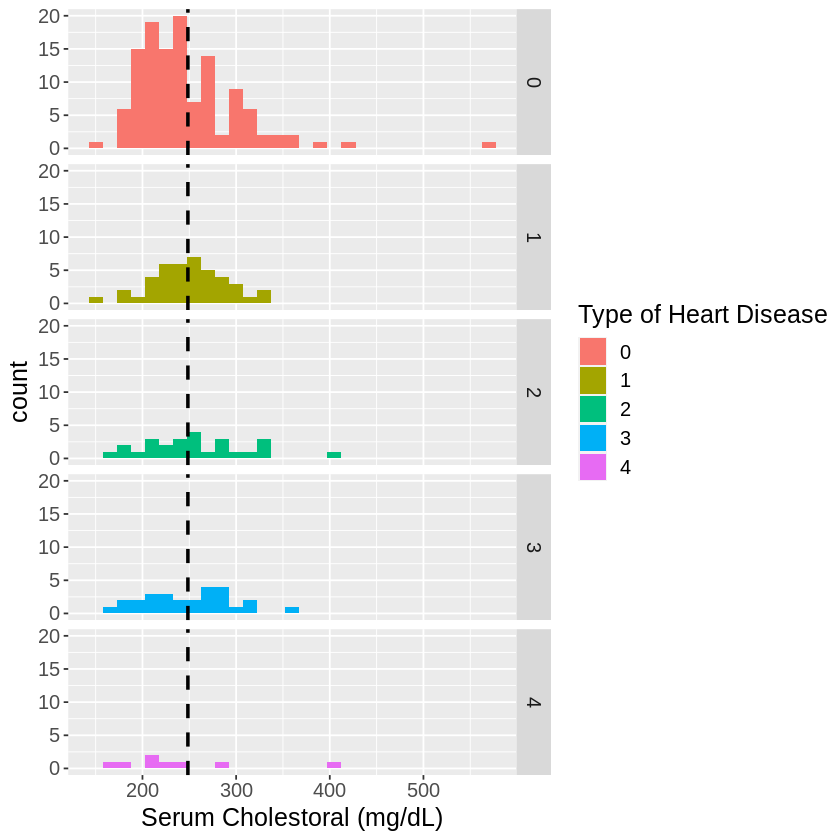

In [169]:
chol_summary_plot <- cleveland_training |>
    ggplot(aes(x = chol, fill = num)) +
    geom_histogram(binwidth = 15) +
    geom_vline(xintercept = 248.5, linetype = "dashed", size = 1.0) +
    labs(x = "Serum Cholestoral (mg/dL)", fill = "Type of Heart Disease") +
    facet_grid(rows = vars(num)) +
    theme(text = element_text(size = 15))

chol_summary_plot

### Fasting Blood Sugar

In [159]:
#pull the number of instances of each type of heart disease
disease_count <- c(123, 42, 26, 27, 8)

fbs_summary <- cleveland_training |>
    group_by(num, fbs) |>
    summarize(count = n()) 

fbs_lower_than_proportion <- fbs_summary |>
    filter(fbs == 0) |> 
    bind_cols(type_count = disease_count) |>
    mutate(lower_than_proportion = count / type_count) |>
    select(num, lower_than_proportion)

fbs_summary
fbs_lower_than_proportion

`summarise()` has grouped output by 'num'. You can override using the `.groups`
argument.


num,fbs,count
<fct>,<fct>,<int>
0,0,107
0,1,16
1,0,38
1,1,4
2,0,21
2,1,5
3,0,21
3,1,6
4,0,8


num,lower_than_proportion
<fct>,<dbl>
0,0.8699187
1,0.9047619
2,0.8076923
3,0.7777778
4,1.0000000


### Resting electrocardiographic

In [160]:
restecg_summary <- cleveland_training |>
    group_by(num, restecg) |>
    summarize(count = n()) |>
    filter(restecg == 0) |> 
    bind_cols(type_count = disease_count) |>
    mutate(normal_proportion = count / type_count) |>
    select(num, normal_proportion)
restecg_summary

`summarise()` has grouped output by 'num'. You can override using the `.groups`
argument.


num,normal_proportion
<fct>,<dbl>
0,0.5934959
1,0.4285714
2,0.5384615
3,0.3703704
4,0.1250000


### Maximum Heart Rate

In [161]:
average_thalach <- cleveland_training |>
    summarize(average_thalach = mean(thalach))
average_thalach

average_thalach
<dbl>
149.4867


In [162]:
average_thalach_by_type <- cleveland_training |>
    group_by(num) |>
    summarize(average_thalach = mean(thalach))
average_thalach_by_type

num,average_thalach
<fct>,<dbl>
0,158.4309
1,147.9762
2,131.9231
3,131.3333
4,138.2500


### Exercise Induced Angina

In [163]:
exang_summary <- cleveland_training |>
    group_by(num, exang) |>
    summarize(count = n()) 

exang_proportion <- exang_summary |>
    filter(exang == 0) |> 
    bind_cols(type_count = disease_count) |>
    mutate(exang_proportion = count / type_count) |>
    select(num, exang_proportion)

exang_summary
exang_proportion

`summarise()` has grouped output by 'num'. You can override using the `.groups`
argument.


num,exang,count
<fct>,<fct>,<int>
0,0,103
0,1,20
1,0,25
1,1,17
2,0,11
2,1,15
3,0,10
3,1,17
4,0,4


num,exang_proportion
<fct>,<dbl>
0,0.8373984
1,0.5952381
2,0.4230769
3,0.3703704
4,0.5000000


### ST Depression

In [164]:
average_oldpeak <- cleveland_training |>
    summarize(average_oldpeak = mean(oldpeak))
average_oldpeak

average_oldpeak
<dbl>
1.033186


In [165]:
average_oldpeak_by_type <- cleveland_training |>
    group_by(num) |>
    summarize(average_oldpeak = mean(oldpeak))
average_oldpeak_by_type

num,average_oldpeak
<fct>,<dbl>
0,0.5910569
1,0.9309524
2,1.8230769
3,1.9925926
4,2.5625000


### Slope of the Peak Exercise ST Segment

In [166]:
slope_summary <- cleveland_training |>
    group_by(num, slope) |>
    summarize(count = n()) 
slope_summary

`summarise()` has grouped output by 'num'. You can override using the `.groups`
argument.


num,slope,count
<fct>,<fct>,<int>
0,1,81
0,2,35
0,3,7
1,1,19
1,2,22
1,3,1
2,1,5
2,2,18
2,3,3


### Number of major vessels colored by flourosopy

In [167]:
ca_summary <- cleveland_training |>
    group_by(num, ca) |>
    summarize(count = n()) 

ca_summary

`summarise()` has grouped output by 'num'. You can override using the `.groups`
argument.


num,ca,count
<fct>,<int>,<int>
0,0,95
0,1,16
0,2,6
0,3,3
0,NA,3
1,0,20
1,1,14
1,2,5
1,3,2
